# Data geometry and margin distributions 
Here I explored some distributions of single trial neural response:
0. baseline and evoked population activation norm
1. margins to category level boundary
2. margins to object level boundary
3. margins to image level boundary

Dataset: solo.rsvp.hvm.experiment_psth.raw.nc (from Sachi)

## Two orthogonal objectives: 1. model quality 2. local sensitivity of the neural representation

**Measuring Model Quality**: SSE or some sampled-based divergence measure between $\epsilon$-target response $\Delta r$ and the measured response $\hat{\Delta r}$, elicited by the model-based controller. 

**Measuring Local sensitivity**: Amount of pixel level change over the amplitude of measured response perturbation $\hat{\Delta r}$, in the direction of $\hat{\Delta r}$. Ideally we measure the full sensitivity function.

Importantly these two things could be measured *independently*. In fact the second can be measured without an image-computable model already in some meaningul directions (i.e. tangent directions of the image) or random directions (random pixel change). 

Quality of single neuron control in V4 is at 64%. What is it in IT?

In [1]:
import xarray as xr
import numpy as np
from brainio_base.assemblies import NeuronRecordingAssembly
%matplotlib notebook
%matplotlib inline
from matplotlib import pyplot,image
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

data = xr.open_dataarray('D:/chongguo/Datasets/solo.rsvp.hvm.experiment_psth.raw.nc')
NeuronRecordingAssembly(data)
# average firing rate between 100 to 150 ms
X0 = data.sel(time_bin=slice(17,22)).mean('time_bin').data*100
# baseline firing rate between -50 to 0 ms
X0_baseline = data.sel(time_bin=slice(2,8)).mean('time_bin').data*100 
# n = number neuroids, p = number patterns
n = np.array(X0.shape[1],'float32')
p = np.array(X0.shape[0],'float32')

ModuleNotFoundError: No module named 'xarray'

## 1. Baseline and evoked response

Optional variance stablizing transformation

In [2]:
varstab = False

def vartrans(x):
    if varstab:
        return np.sqrt(x)
    else:
        return x

X = vartrans(X0)
X_baseline = vartrans(X0_baseline)

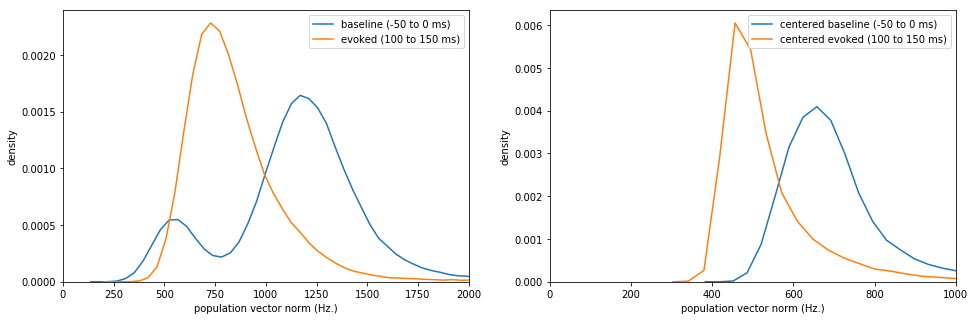

In [23]:
x_evoked_mean = np.mean(X,axis=0)
x_baseline_mean = np.mean(X_baseline,axis=0)
X_centered_evoked = X-x_evoked_mean
X_centered_baseline = X_baseline-x_baseline_mean
dist_mean = np.linalg.norm(X,axis = 1)
dist_to_mean = np.linalg.norm(X_centered_evoked,axis = 1)
dist_baseline = np.linalg.norm(X_baseline,axis=1)
dist_to_baseline = np.linalg.norm(X_centered_baseline,axis = 1)
pyplot.figure(figsize=(16,5))
pyplot.subplot(1,2,1)
sns.distplot(dist_baseline,bins=100,hist = False, kde = True, label = 'baseline (-50 to 0 ms)')
sns.distplot(dist_mean,bins=100,hist = False, kde = True, label = 'evoked (100 to 150 ms)')
pyplot.xlabel('population vector norm (Hz.)')
pyplot.xlim((0,2000))
pyplot.ylabel('density')
pyplot.legend()
pyplot.subplot(1,2,2)
sns.distplot(dist_to_baseline,bins=100,hist = False, kde = True, label = 'centered baseline (-50 to 0 ms)')
sns.distplot(dist_to_mean,bins=100,hist = False, kde = True, label = 'centered evoked (100 to 150 ms)')
pyplot.xlabel('population vector norm (Hz.)')
pyplot.xlim((0,1000))
pyplot.ylabel('density')
pyplot.legend()

pyplot.show()

Visual input lowers average neural activity. Still a distributional difference after accounting for average shift in evoked population response. Strange bimodal baseline. Now take a look at the dimensionality of the centered evoked response.

In [4]:
from sklearn.decomposition import PCA
%matplotlib inline
pca = PCA(n_components=min(np.int(n),np.int(p)))
pca.fit(X_centered_evoked)
X_pca = pca.transform(X_centered_evoked)

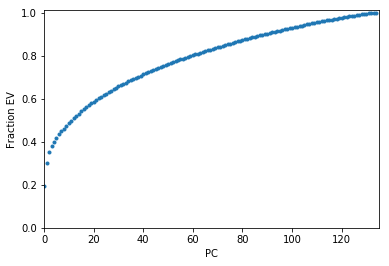

In [5]:
pyplot.plot(np.cumsum(pca.explained_variance_ratio_),'.')
pyplot.xlabel('PC')
pyplot.ylabel('Fraction EV')
pyplot.ylim((0,1.01))
pyplot.xlim((0,n))
pyplot.show()

In [6]:
X_lambda = pca.singular_values_
est_dim = np.sum(X_lambda)**2/np.sum(X_lambda**2)
print('The estimated dimensionality of centered evoked response is:', round(est_dim))

The estimated dimensionality of centered evoked response is: 95.0


This is rather big. It's unclear yet how much of this is noise. So now we look at trial(28x) smoothed response.

In [7]:
X0_smooth = data.sel(time_bin=slice(17,22)).mean('time_bin').groupby('image_id').mean('presentation').data*100
X0_smooth_baseline = data.sel(time_bin=slice(2,8)).mean('time_bin').groupby('image_id').mean('presentation').data*100

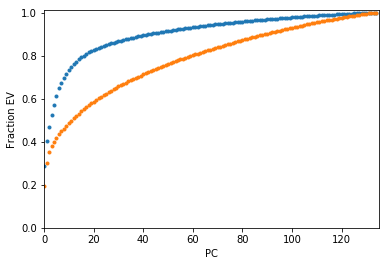

The estimated dimensionality of trial-smoothed centered evoked response is: 60.0


In [8]:
X_smooth = vartrans(X0_smooth)
x_smooth_mean = np.mean(X_smooth,axis=0)
X_centered_evk_smooth = X_smooth-x_smooth_mean

pca_smooth = PCA(n_components=min(np.int(n),np.int(p)))
pca_smooth.fit(X_centered_evk_smooth)
X_evk_smooth_pca = pca_smooth.transform(X_centered_evk_smooth)

pyplot.plot(np.cumsum(pca_smooth.explained_variance_ratio_),'.', label='trial-smoothed')
pyplot.plot(np.cumsum(pca.explained_variance_ratio_),'.',label='noisy')
pyplot.xlabel('PC')
pyplot.ylabel('Fraction EV')
pyplot.ylim((0,1.01))
pyplot.xlim((0,n))
pyplot.show()

X_evk_smooth_lambda = pca_smooth.singular_values_
est_evk_smooth_dim = np.sum(X_evk_smooth_lambda)**2/np.sum(X_evk_smooth_lambda**2)
print('The estimated dimensionality of trial-smoothed centered evoked response is:', round(est_evk_smooth_dim))

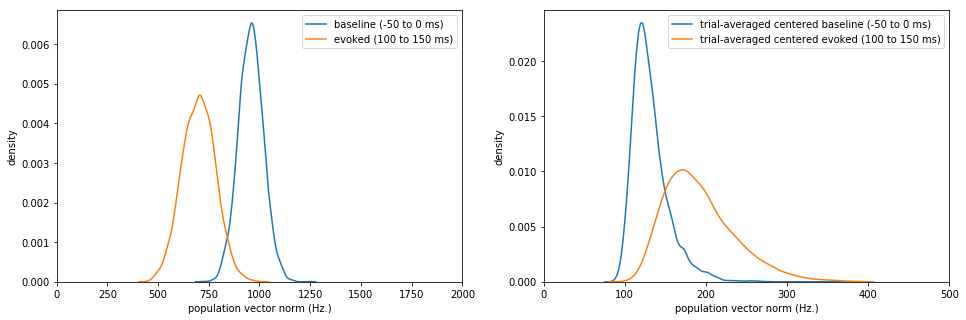

In [24]:
X_smooth = vartrans(X0_smooth)
X_smooth_baseline = vartrans(X0_smooth_baseline)

x_smooth_evoked_mean = np.mean(X_smooth,axis=0)
x_smooth_baseline_mean = np.mean(X_smooth_baseline,axis=0)
X_smooth_centered_evoked = X_smooth-x_smooth_evoked_mean
X_smooth_centered_baseline = X_smooth_baseline-x_smooth_baseline_mean
dist_s_mean = np.linalg.norm(X_smooth,axis = 1)
dist_s_to_mean = np.linalg.norm(X_smooth_centered_evoked,axis = 1)
dist_s_baseline = np.linalg.norm(X_smooth_baseline,axis=1)
dist_s_to_baseline = np.linalg.norm(X_smooth_centered_baseline,axis = 1)
pyplot.figure(figsize=(16,5))
pyplot.subplot(1,2,1)
sns.distplot(dist_s_baseline,bins=100,hist = False, kde = True, label = 'baseline (-50 to 0 ms)')
sns.distplot(dist_s_mean,bins=100,hist = False, kde = True, label = 'evoked (100 to 150 ms)')
pyplot.xlabel('population vector norm (Hz.)')
pyplot.xlim((0,2000))
pyplot.ylabel('density')
pyplot.legend()
pyplot.subplot(1,2,2)
sns.distplot(dist_s_to_baseline,hist = False, kde = True, label = 'trial-averaged centered baseline (-50 to 0 ms)')
sns.distplot(dist_s_to_mean,hist = False, kde = True, label = 'trial-averaged centered evoked (100 to 150 ms)')
pyplot.xlabel('population vector norm (Hz.)')
pyplot.xlim((0,500))
pyplot.ylabel('density')
pyplot.legend()

pyplot.show()

Redoing the analysis from earlier, we find that the evoked response decrease but after centering, evoked response to individual images are more spread out as compared to baseline response. Now we compare this with the centered evoked response from earlier to get an estimate of the SNR for single trial response.

In [10]:
def centering(x):
    return vartrans(x*100) - vartrans(x*100).mean('presentation')

X0_noise = data.sel(time_bin=slice(17,22)).mean('time_bin').groupby('image_id').apply(centering).data
X0_signal_noise = data.sel(time_bin=slice(17,22)).mean('time_bin').data*100

In [11]:
X_noise_centered_evoked = X0_noise
dist_n_to_mean = np.linalg.norm(X_noise_centered_evoked,axis = 1)
X_sig_noise_centered_evoked = vartrans(X0_signal_noise)-x_smooth_evoked_mean
dist_sn_to_mean = np.linalg.norm(X_sig_noise_centered_evoked,axis = 1)
X_sig_noise_evoked = vartrans(X0_signal_noise)
dist_sn0_to_mean = np.linalg.norm(X_sig_noise_evoked,axis = 1)

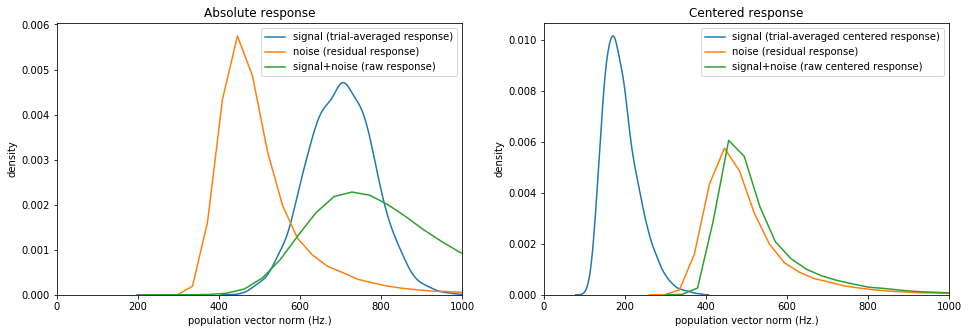

In [12]:
pyplot.figure(figsize=(16,5))
pyplot.subplot(1,2,1)
sns.distplot(dist_s_mean,hist = False, kde = True, label = 'signal (trial-averaged response)')
sns.distplot(dist_n_to_mean,hist = False, kde = True, label = 'noise (residual response)')
sns.distplot(dist_sn0_to_mean,hist = False, kde = True, label = 'signal+noise (raw response)')
pyplot.xlabel('population vector norm (Hz.)')
pyplot.xlim((0,1000))
pyplot.ylabel('density')
pyplot.legend()
pyplot.title('Absolute response')
pyplot.subplot(1,2,2)
sns.distplot(dist_s_to_mean,hist = False, kde = True, label = 'signal (trial-averaged centered response)')
sns.distplot(dist_n_to_mean,hist = False, kde = True, label = 'noise (residual response)')
sns.distplot(dist_sn_to_mean,hist = False, kde = True, label = 'signal+noise (raw centered response)')
pyplot.xlabel('population vector norm (Hz.)')
pyplot.xlim((0,1000))
pyplot.ylabel('density')
pyplot.title('Centered response')
pyplot.legend()
pyplot.show()

In [28]:
mu_S0 = np.median(dist_s_mean)
mu_S = np.median(dist_s_to_mean)
sig_N = np.median(dist_n_to_mean)
SNR = mu_S/sig_N
print('Abs signal strength is ~', np.round(mu_S0,2))
print('Signal strength is ~', np.round(mu_S,2))
print('Noise strength is ~', np.round(sig_N,2))
print('Single trial, SNR is approx.', np.round(SNR,2), 'assuming uncorrelated noise')

Abs signal strength is ~ 701.03
Signal strength is ~ 185.01
Single trial, SNR is approx. 0.39 assuming uncorrelated noise


Assuming we are close to convergence here the SNR ratio will increase as a function of $\sqrt{n_{trials}}$. So we could get around it by both sampling more trials (4-5?) per target and select larger $\epsilon$ perturbation (larger than typical ). The later works best if we select targets with the same or less average population activation so we avoid simutaneously blowing up the noise. The goal is to have high enough SNR for asessing the controller quality. More trials takes time but so we prefer larger $\epsilon$, but it needs to stay 'local' in the sense that we are not violating say category label. So how far could we navigate away while staying in the same category?  

## 2. Margin distribution to category level boundaries
We build multiple one-vs-all decoders, then measure the distance of responses in each category to its decision boundary

In [14]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
ycat = LE.fit_transform(data.category_name.data)
datar = data.sel(time_bin=slice(17,22)).mean('time_bin').groupby('image_id').mean('presentation')

uimg = datar.image_id.data
yimg = data.image_id.data
y = np.zeros(uimg.size)
for i,u in enumerate(uimg,start=0):
    tempv = ycat[yimg==u]
    y[i] = np.int(tempv[0]+1)
Xsvc = X_evk_smooth_pca/100

In [15]:
npatterns = len(y)
ncells = Xsvc.shape[1]
ntrain = np.int(npatterns/3*2)
ntest = npatterns-ntrain
nclass = len(np.unique(y))
X_train = Xsvc[:ntrain,:]
y_train = y[:ntrain]
X_test = Xsvc[ntrain:,:]
y_test = y[ntrain:]

In [16]:
Cs = [1e-1,1,1e1]
trainscore = np.zeros((len(Cs),1))
testscore = np.zeros((len(Cs),1))
margintrain = np.zeros((ntrain,len(Cs)))
margintest = np.zeros((ntest,len(Cs)))

bestscore = 0
for i in range(len(Cs)):
    clf = LinearSVC(multi_class = 'crammer_singer' ,C = Cs[i], max_iter = 2000,tol=1e-5)
    clf.fit(X_train, y_train)
    trainscore[i] = clf.score(X_train,y_train)
    testscore[i] = clf.score(X_test,y_test)
    tempmargin = np.empty((0))
    for j in range(nclass):
        margins = clf.decision_function(X_train[y_train==j+1,:])
        tempmargin = np.append(tempmargin,margins[:,j],axis=0)/np.linalg.norm(clf.coef_[j,:])
    margintrain[:,i] = tempmargin
    tempmargin = np.empty((0))
    for j in range(nclass):
        margins = clf.decision_function(X_test[y_test==j+1,:])
        tempmargin = np.append(tempmargin,margins[:,j],axis=0)/np.linalg.norm(clf.coef_[j,:])
    margintest[:,i] = tempmargin
    if bestscore < testscore[i]:
        clf_best = clf;

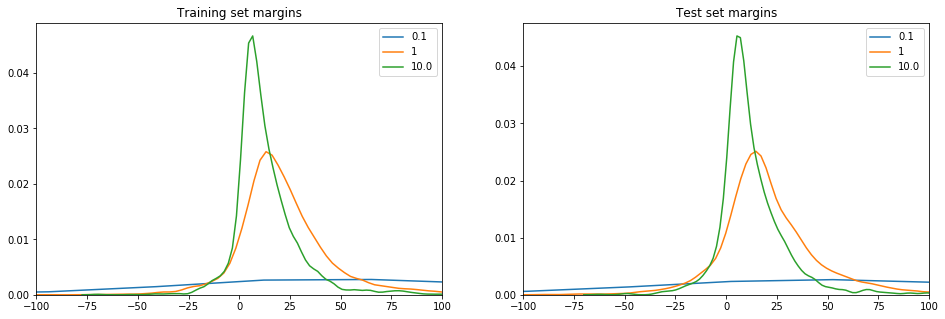

In [17]:
pyplot.figure(figsize = (16,5))
pyplot.subplot(1,2,1)
for i in range(len(Cs)):
    sns.distplot(margintrain[:,i]*100,hist = False, kde=True,label=Cs[i])
pyplot.title('Training set margins')
pyplot.xlim((-100,100))
pyplot.subplot(1,2,2)
for i in range(len(Cs)):
    sns.distplot(margintest[:,i]*100,hist = False, kde=True,label=Cs[i])
pyplot.title('Test set margins')
pyplot.xlim((-100,100))
pyplot.show()

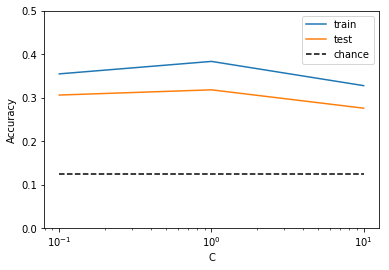

In [18]:
pyplot.semilogx(Cs,trainscore,label='train')
pyplot.semilogx(Cs,testscore,label='test')
pyplot.semilogx([Cs[0],Cs[-1]],[.125,.125],'k--',label='chance')
pyplot.ylim((0,.5))
pyplot.xlabel('C')
pyplot.ylabel('Accuracy')
pyplot.legend()
pyplot.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

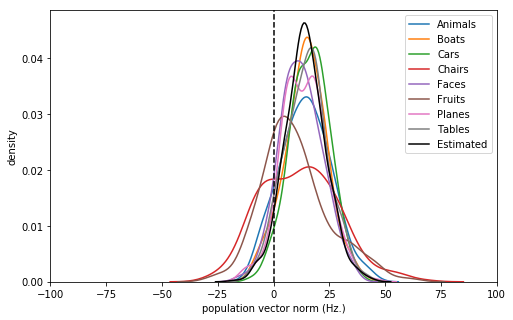

In [19]:
mm = np.zeros(nclass)
ms = np.zeros(nclass)
pyplot.figure(figsize=(8,5))
for c in range(8):
    margins = clf_best.decision_function(X_test[y_test==c+1,:])/np.linalg.norm(clf_best.coef_[c,:])
    sns.distplot(margins[:,c]*100,hist=False,label=LE.inverse_transform(c))
    mm[c] = np.nanmedian(margins[:,c]*100)
    ms[c] = np.std(margins[:,c]*100)
nullmargins = clf_best.decision_function(np.random.normal(0,np.median(ms),size=(1000,ncells)))/np.linalg.norm(clf_best.coef_[0,:])
sns.distplot(nullmargins[:,0]+np.median(mm),hist=False,label='Estimated',color='k')
pyplot.legend()
pyplot.xlabel('population vector norm (Hz.)')
pyplot.ylabel('density')
pyplot.axvline(0,color='k',linestyle='--')
pyplot.xlim((-100,100))
pyplot.show()

In [20]:
print('Average margin = ', np.round(np.median(mm),4))
print('Margin deviance = ', np.round(np.median(ms),4))

Average margin =  14.2263
Margin deviance =  9.7485


A local perturbation respecting category encoding is ~ 14 Hz (compared with 185Hz population signal, ~701Hz abs evoked signal). Assuming perturbation is distributed over the population, this translates to ~1.2 Hz per neuron (compared with ~16 Hz signal per neuron and 60Hz abs evoked signal). This feels bad because the estimated single-trial noise component per neuron is ~16Hz or 185Hz over pop.). IT must keep the projected noise in this *worst-case-direction* below the average margin on each trial to support category-level object recognition. This is the natural equivalent to adversarial attack for DNNs. 

So what is the expected projected noise amplitude for a 185Hz pop noise vector in any random direction?

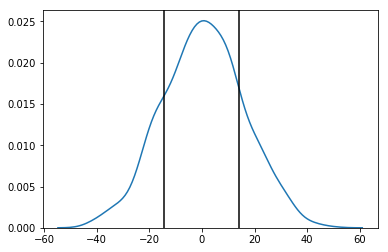

Fraction of trials with noise smaller than worse-case-margin is: 0.637


In [56]:
randdir = np.random.normal(0,1,ncells)
randdir = randdir/np.linalg.norm(randdir)
noisevect = np.random.normal(0,1,size=(1000,ncells))
for i in range(1000):
    noisevect[i,:] = noisevect[i,:]/np.linalg.norm(noisevect[i,:])*185
noiseproj = np.matmul(noisevect,randdir)
sns.distplot(noiseproj,kde=True,hist=False)
pyplot.axvline(np.median(mm),color='k')
pyplot.axvline(-np.median(mm),color='k')
pyplot.show()
fracwrong = np.sum(np.abs(noiseproj)>np.median(mm))/1000
print('Fraction of trials with noise smaller than worse-case-margin is:', 1-fracwrong)

## 3. Margin distribution to object level boundaries
We build multiple one-vs-all decoders, then measure the distance of responses in each object to its decision boundary

In [57]:
LEO = LabelEncoder()
yobj = LEO.fit_transform(data.object_name.data)

y = np.zeros(uimg.size)
for i,u in enumerate(uimg,start=0):
    tempv = yobj[yimg==u]
    y[i] = np.int(tempv[0]+1)
Xsvc = X_evk_smooth_pca/100

In [58]:
npatterns = len(y)
ntrain = np.int(npatterns/3*2)
ntest = npatterns-ntrain
nclass = len(np.unique(y))
X_train = Xsvc[:ntrain,:]
y_train = y[:ntrain]
X_test = Xsvc[ntrain:,:]
y_test = y[ntrain:]

In [59]:
Cs = [.0001,.001,.01,.1,1,10,100]
trainscore = np.zeros((len(Cs),1))
testscore = np.zeros((len(Cs),1))
margintrain = np.zeros((ntrain,len(Cs)))
margintest = np.zeros((ntest,len(Cs)))

bestscore = 0
for i in range(len(Cs)):
    clf = LinearSVC(random_state=10 ,C = Cs[i], max_iter = 5000,tol=1e-2)
    clf.fit(X_train, y_train)
    trainscore[i] = clf.score(X_train,y_train)
    testscore[i] = clf.score(X_test,y_test)
    tempmargin = np.empty((0))
    for j in range(nclass):
        margins = clf.decision_function(X_train[y_train==j+1,:])
        tempmargin = np.append(tempmargin,margins[:,j],axis=0)/np.linalg.norm(clf.coef_[j,:])
    margintrain[:,i] = tempmargin
    tempmargin = np.empty((0))
    for j in range(nclass):
        margins = clf.decision_function(X_test[y_test==j+1,:])
        tempmargin = np.append(tempmargin,margins[:,j],axis=0)/np.linalg.norm(clf.coef_[j,:])
    margintest[:,i] = tempmargin
    if bestscore < testscore[i]:
        clf_best = clf;

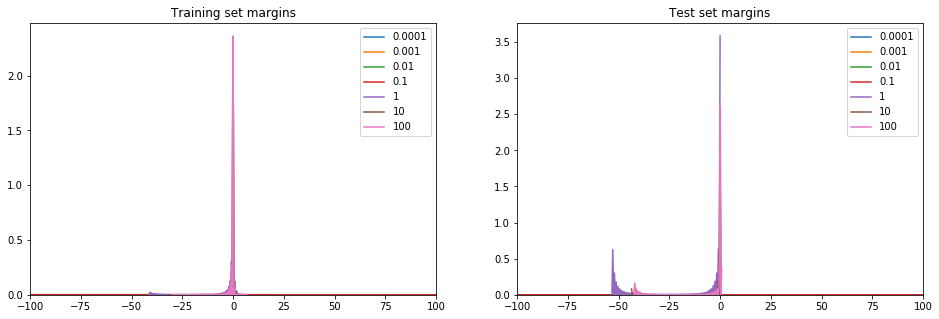

In [60]:
pyplot.figure(figsize = (16,5))
pyplot.subplot(1,2,1)
for i in range(len(Cs)):
    sns.distplot(margintrain[:,i]*100,hist = False, kde=True,label=Cs[i])
pyplot.title('Training set margins')
pyplot.xlim((-100,100))
pyplot.subplot(1,2,2)
for i in range(len(Cs)):
    sns.distplot(margintest[:,i]*100,hist = False, kde=True,label=Cs[i])
pyplot.title('Test set margins')
pyplot.xlim((-100,100))
pyplot.show()

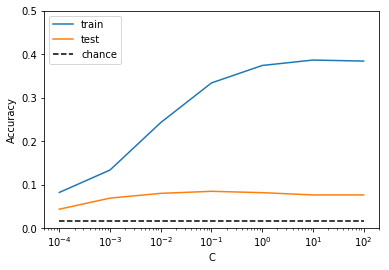

In [61]:
pyplot.semilogx(Cs,trainscore,label='train')
pyplot.semilogx(Cs,testscore,label='test')
pyplot.semilogx([Cs[0],Cs[-1]],[1/nclass,1/nclass],'k--',label='chance')
pyplot.ylim((0,.5))
pyplot.xlabel('C')
pyplot.ylabel('Accuracy')
pyplot.legend()
pyplot.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

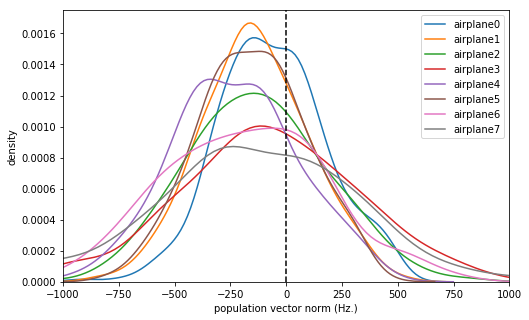

In [70]:
pyplot.figure(figsize=(8,5))
for c in range(nclass):
    margins = clf_best.decision_function(X_test[y_test==c+1,:])
    sns.distplot(margins[:,c]*100,hist=False,label=LEO.inverse_transform(c))
pyplot.legend()
pyplot.xlabel('population vector norm (Hz.)')
pyplot.ylabel('density')
pyplot.axvline(0,color='k',linestyle='--')
pyplot.xlim((-1000,1000))
pyplot.show()

### Check intuition for what's going on
look at the decision function vs the decision surface as a function of cluster overlap

Three different ways of calculating margin yields qualitatively different result:
for n classes
1. independent n one-vs-rest
2. cramer singer (jointly optimized n)
3. n(n-1)/2 pair-wise comparison then majority vote

In [63]:
from sklearn.utils import shuffle
c = 1
nclass = 8 # bigger than 2
nsamp = 720
ndim = 135
offset = 2.
y = np.empty(0)
X = np.empty((0,ndim))
ntrain = round(nclass*nsamp*.5)
for i in range(nclass):
    randX = np.random.multivariate_normal(np.zeros(ndim),np.eye(ndim),nsamp)
    Xrot = np.random.normal(0,1,ndim)
    Xrot = Xrot/np.linalg.norm(Xrot)*offset
    X = np.vstack((X,Xrot+randX))
    y = np.append(y,np.ones(nsamp)*(i+1))
X,y = shuffle(X,y)
X_train = X[0::2][:];
y_train = y[0::2];
X_test = X[1::2][:];
y_test = y[1::2];

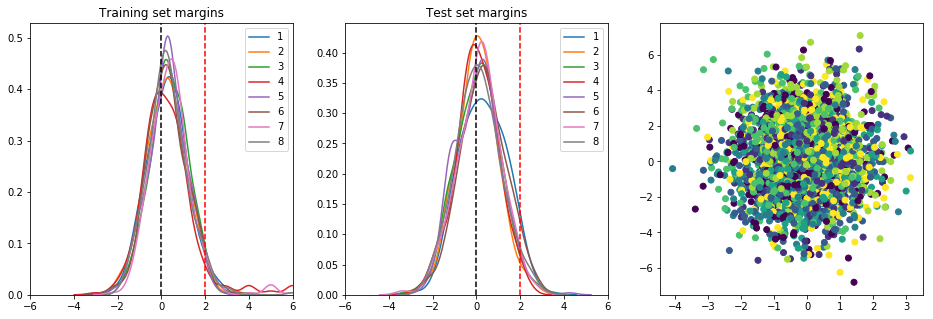

train: 0.7681   test: 0.6719
typical offset of:  1.6042742904212102


In [64]:
# one vs rest
# fit linear svm
clf = LinearSVC(C = c, max_iter = 2000,tol=1e-5)
clf.fit(X_train, y_train)
nsamptrain = round(ntrain/nclass)
trainmargin = np.empty((nsamptrain,nclass))
for j in range(nclass):
    margins = clf.decision_function(X_train[y_train==j+1,:])
    ninc = min(margins.shape[0],nsamptrain)
    trainmargin[:ninc,j] = margins[:ninc,j]/np.linalg.norm(clf.coef_[j,:])
nsamptest = round(ntrain/nclass)
testmargin = np.empty((nsamptest,nclass))
for j in range(nclass):
    margins = clf.decision_function(X_test[y_test==j+1,:])
    ninc = min(margins.shape[0],nsamptrain)
    testmargin[:ninc,j] = margins[:ninc,j]/np.linalg.norm(clf.coef_[j,:])

pyplot.figure(figsize = (16,5))
pyplot.subplot(1,3,1)
for i in range(nclass):
    sns.distplot(trainmargin[:,i],hist = False, kde=True,label=i+1)
pyplot.title('Training set margins')
pyplot.xlim((-offset*3,offset*3))
pyplot.axvline(0,color = 'k', linestyle = '--')
pyplot.axvline(offset,color = 'r', linestyle = '--')
pyplot.subplot(1,3,2)
for i in range(nclass):
    sns.distplot(testmargin[:,i],hist = False, kde=True,label=i+1)
pyplot.title('Test set margins')
pyplot.axvline(0,color = 'k', linestyle = '--')
pyplot.axvline(offset,color = 'r', linestyle = '--')
pyplot.xlim((-offset*3,offset*3))
pyplot.subplot(1,3,3)
pyplot.scatter(X_test[:,0],X_test[:,1]*offset,c=y_test)
pyplot.show()

typicaloffset = np.mean(abs(clf.intercept_/np.linalg.norm(clf.coef_,axis=1)))
trainscore = clf.score(X_train,y_train)
testscore = clf.score(X_test,y_test)
print('train:', round(trainscore,4), '  test:', round(testscore,4))
print('typical offset of: ',typicaloffset)

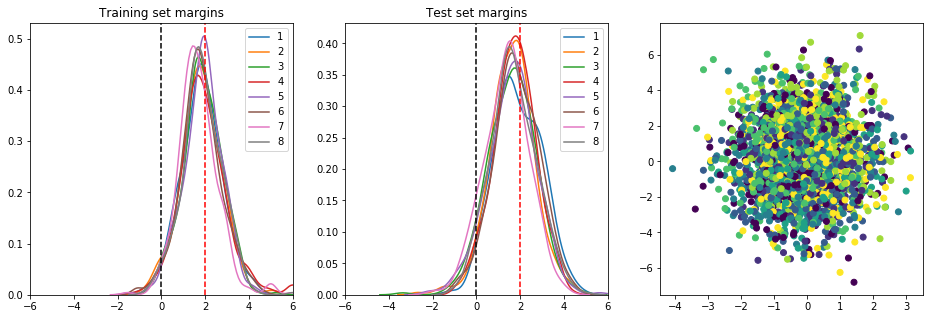

train: 0.8007   test: 0.6483
typical offset of:  0.08686735045025273


In [65]:
# cramer singer

# fit linear svm
clf = LinearSVC(multi_class = 'crammer_singer',C = c, max_iter = 2000,tol=1e-5)
clf.fit(X_train, y_train)
nsamptrain = round(ntrain/nclass)
trainmargin = np.empty((nsamptrain,nclass))
for j in range(nclass):
    margins = clf.decision_function(X_train[y_train==j+1,:])
    ninc = min(margins.shape[0],nsamptrain)
    trainmargin[:ninc,j] = margins[:ninc,j]/np.linalg.norm(clf.coef_[j,:])
nsamptest = round(ntrain/nclass)
testmargin = np.empty((nsamptest,nclass))
for j in range(nclass):
    margins = clf.decision_function(X_test[y_test==j+1,:])
    ninc = min(margins.shape[0],nsamptrain)
    testmargin[:ninc,j] = margins[:ninc,j]/np.linalg.norm(clf.coef_[j,:])

pyplot.figure(figsize = (16,5))
pyplot.subplot(1,3,1)
for i in range(nclass):
    sns.distplot(trainmargin[:,i],hist = False, kde=True,label=i+1)
pyplot.title('Training set margins')
pyplot.xlim((-offset*3,offset*3))
pyplot.axvline(0,color = 'k', linestyle = '--')
pyplot.axvline(offset,color = 'r', linestyle = '--')
pyplot.subplot(1,3,2)
for i in range(nclass):
    sns.distplot(testmargin[:,i],hist = False, kde=True,label=i+1)
pyplot.title('Test set margins')
pyplot.axvline(0,color = 'k', linestyle = '--')
pyplot.axvline(offset,color = 'r', linestyle = '--')
pyplot.xlim((-offset*3,offset*3))
pyplot.subplot(1,3,3)
pyplot.scatter(X_test[:,0],X_test[:,1]*offset,c=y_test)
pyplot.show()

typicaloffset = np.mean(abs(clf.intercept_/np.linalg.norm(clf.coef_,axis=1)))
trainscore = clf.score(X_train,y_train)
testscore = clf.score(X_test,y_test)
print('train:', round(trainscore,4), '  test:', round(testscore,4))
print('typical offset of: ',typicaloffset)

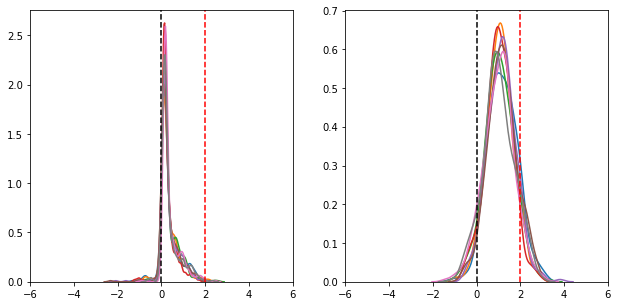

train: 0.9715   test: 0.5896
typical offset of:  0.002431641925204107


In [66]:
# one vs one
# generate an index and sign over the pairwise hyperplanes
index = np.zeros((nclass-1,nclass),dtype = int)
signw = np.ones((nclass-1,nclass))
endindx = 0
for j in range(nclass-1):
    startindx = endindx
    endindx = startindx + nclass-j-1
    index[j,j+1:] = range(startindx,endindx)
    index[j:,j] = range(startindx,endindx)
    signw[j,j+1:] = -1
    
# fit linear svm
clf = SVC(kernel='linear',decision_function_shape = 'ovo',C = c, max_iter = 2000,tol=1e-5)
clf.fit(X_train, y_train)
nsamptrain = round(ntrain/nclass)
trainmargin = np.empty((nsamptrain,nclass))


pyplot.figure(figsize = (16,5))
pyplot.subplot(1,3,1)
for k in range(nclass):
    allmargins = clf.decision_function(X_train[y_train==k+1,:])
    margins = allmargins[:,index[:,k]]*signw[:,k]
    normmargin = margins
    for j in range(nclass-1):
        normmargin[:,j] = margins[:,j]/np.linalg.norm(clf.coef_[index[j,k],:])
    sns.distplot(np.min(normmargin,axis=1),hist = False, kde = True)
pyplot.xlim((-offset*3,offset*3))
pyplot.axvline(0,color = 'k', linestyle = '--')
pyplot.axvline(offset,color = 'r', linestyle = '--')
pyplot.subplot(1,3,2)
for k in range(nclass):
    allmargins = clf.decision_function(X_test[y_test==k+1,:])
    margins = allmargins[:,index[:,k]]*signw[:,k]
    normmargin = margins
    for j in range(nclass-1):
        normmargin[:,j] = margins[:,j]/np.linalg.norm(clf.coef_[index[j,k],:])
    sns.distplot(np.mean(normmargin,axis=1),hist = False, kde = True)
pyplot.xlim((-offset*3,offset*3))
pyplot.axvline(0,color = 'k', linestyle = '--')
pyplot.axvline(offset,color = 'r', linestyle = '--')
pyplot.show()

typicaloffset = np.min(abs(clf.intercept_/np.linalg.norm(clf.coef_,axis=1)))
trainscore = clf.score(X_train,y_train)
testscore = clf.score(X_test,y_test)
print('train:', round(trainscore,4), '  test:', round(testscore,4))
print('typical offset of: ',typicaloffset)

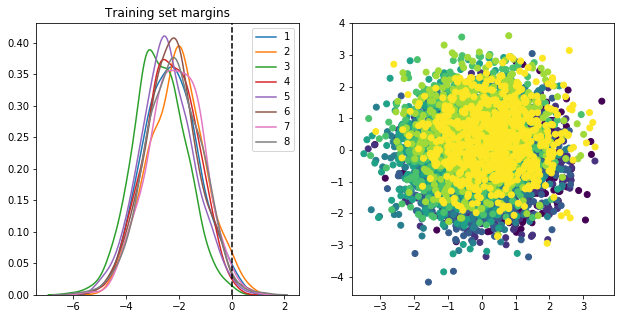

[-2.64537082 -2.43029477 -2.99729427 -2.59126455 -2.83552549 -2.61137508
 -2.43836895 -2.55017535]
0.20347222222222222


In [67]:
offset = .5
X0 = np.zeros(ndim)
X0[0] = offset
y = np.empty(0)
X = np.empty((0,ndim))
for i in range(nclass):
    randX = np.random.multivariate_normal(np.zeros(ndim),np.eye(ndim),nsamp)
    theta = i*np.radians(360/nclass)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    Xrot = np.zeros(ndim)
    Xrot[:][:2]= np.matmul(X0[:][:2],R)
    X = np.vstack((X,Xrot+randX))
    y = np.append(y,np.ones(nsamp)*(i+1))

X = X/offset
# fit linear svm
clf = LinearSVC(random_state=0 ,C = 1, max_iter = 1000,tol=1e-5)
clf.fit(X, y)
tempmargin = np.empty((nsamp,nclass))
for j in range(nclass):
    margins = clf.decision_function(X[y==j+1,:])
    tempmargin[:,j] = margins[:,j]/np.linalg.norm(clf.coef_[j,:])

pyplot.figure(figsize = (16,5))
pyplot.subplot(1,3,1)
for i in range(nclass):
    sns.distplot(tempmargin[:,i]*offset,hist = False, kde=True,label=i+1)
pyplot.title('Training set margins')
pyplot.axvline(0,color = 'k', linestyle = '--')
pyplot.subplot(1,3,2)
pyplot.scatter(X[:,0]*offset,X[:,1]*offset,c=y)
pyplot.show()
print(clf.intercept_/np.linalg.norm(clf.coef_,axis=1)*offset)
print(clf.score(X,y))

What happens to the margin as a function of dimensionality?

## Distance between object class


In [68]:
npatterns/nclass

720.0